In [79]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import find_peaks, butter, filtfilt, resample, savgol_filter

In [27]:
# Data Loading

ecg1, ppg1 = np.load('data/first_ecg.npy'), np.load('data/first_ppg.npy')
ecg2, ppg2 = np.load('data/second_ecg.npy'), np.load('data/second_ppg.npy')
ecg3, ppg3 = np.load('data/third_ecg.npy'), np.load('data/third_ppg.npy')

### Task 1: Sampling frequencies detection

The normal resting heart rate is known to be in range 60 to 100 bits per minute (bpm). We will use this range to estimate the sample frequencies.

But firstly, let's visualize the data

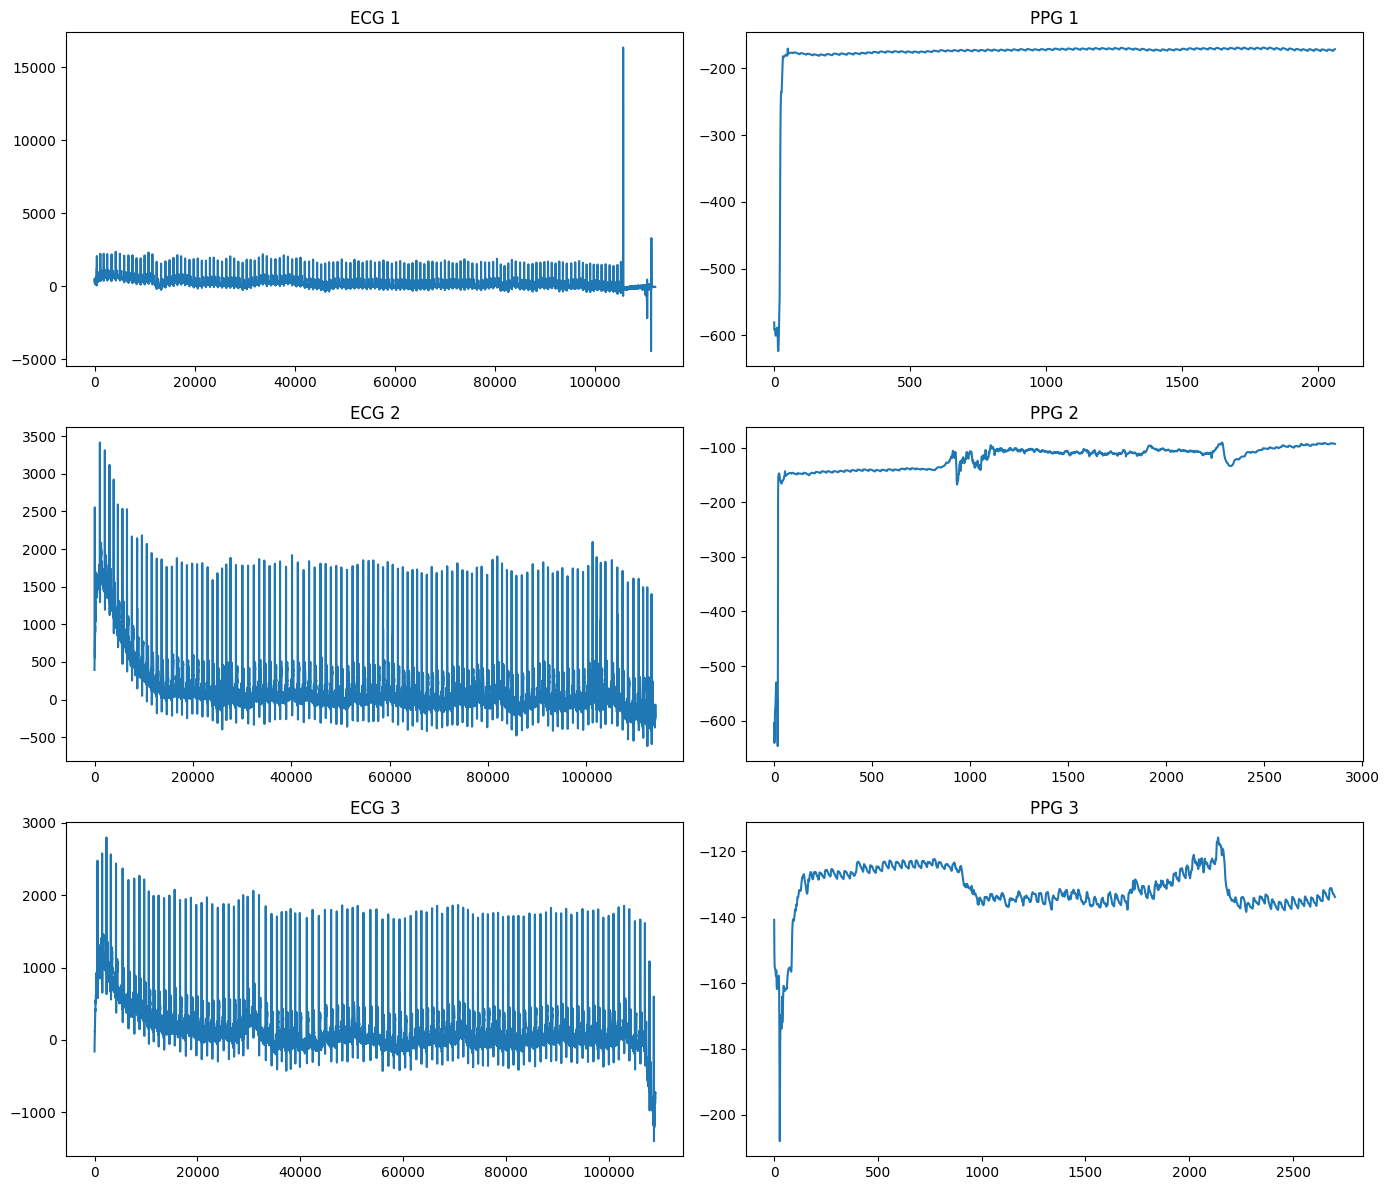

In [28]:
# Create the plots
fig, axs = plt.subplots(3, 2, figsize=(14, 12))

# Plot ECG and PPG for the first dataset
axs[0, 0].plot(ecg1)
axs[0, 0].set_title('ECG 1')
axs[0, 1].plot(ppg1)
axs[0, 1].set_title('PPG 1')

# Plot ECG and PPG for the second dataset
axs[1, 0].plot(ecg2)
axs[1, 0].set_title('ECG 2')
axs[1, 1].plot(ppg2)
axs[1, 1].set_title('PPG 2')

# Plot ECG and PPG for the third dataset
axs[2, 0].plot(ecg3)
axs[2, 0].set_title('ECG 3')
axs[2, 1].plot(ppg3)
axs[2, 1].set_title('PPG 3')

# Adjust layout for better readability
plt.tight_layout()
plt.show()

To estimate the sampling frequency we will use the following relation:

$$F_s = \frac{N}{T}$$

where $N$ is a distance between two peaks and $T = X \; bps$ is a typical time between the peaks.

For the whole dataset, we will use 

$$\hat{F_s} = \frac{\sum \limits_{all \; consecutive \; peak \; pairs}N}{n*Xbps}$$
where $n$ is a number of peaks in the dataset.

ECG: R peaks and RR intervals

PPG: Systolic peaks and intervals between them.

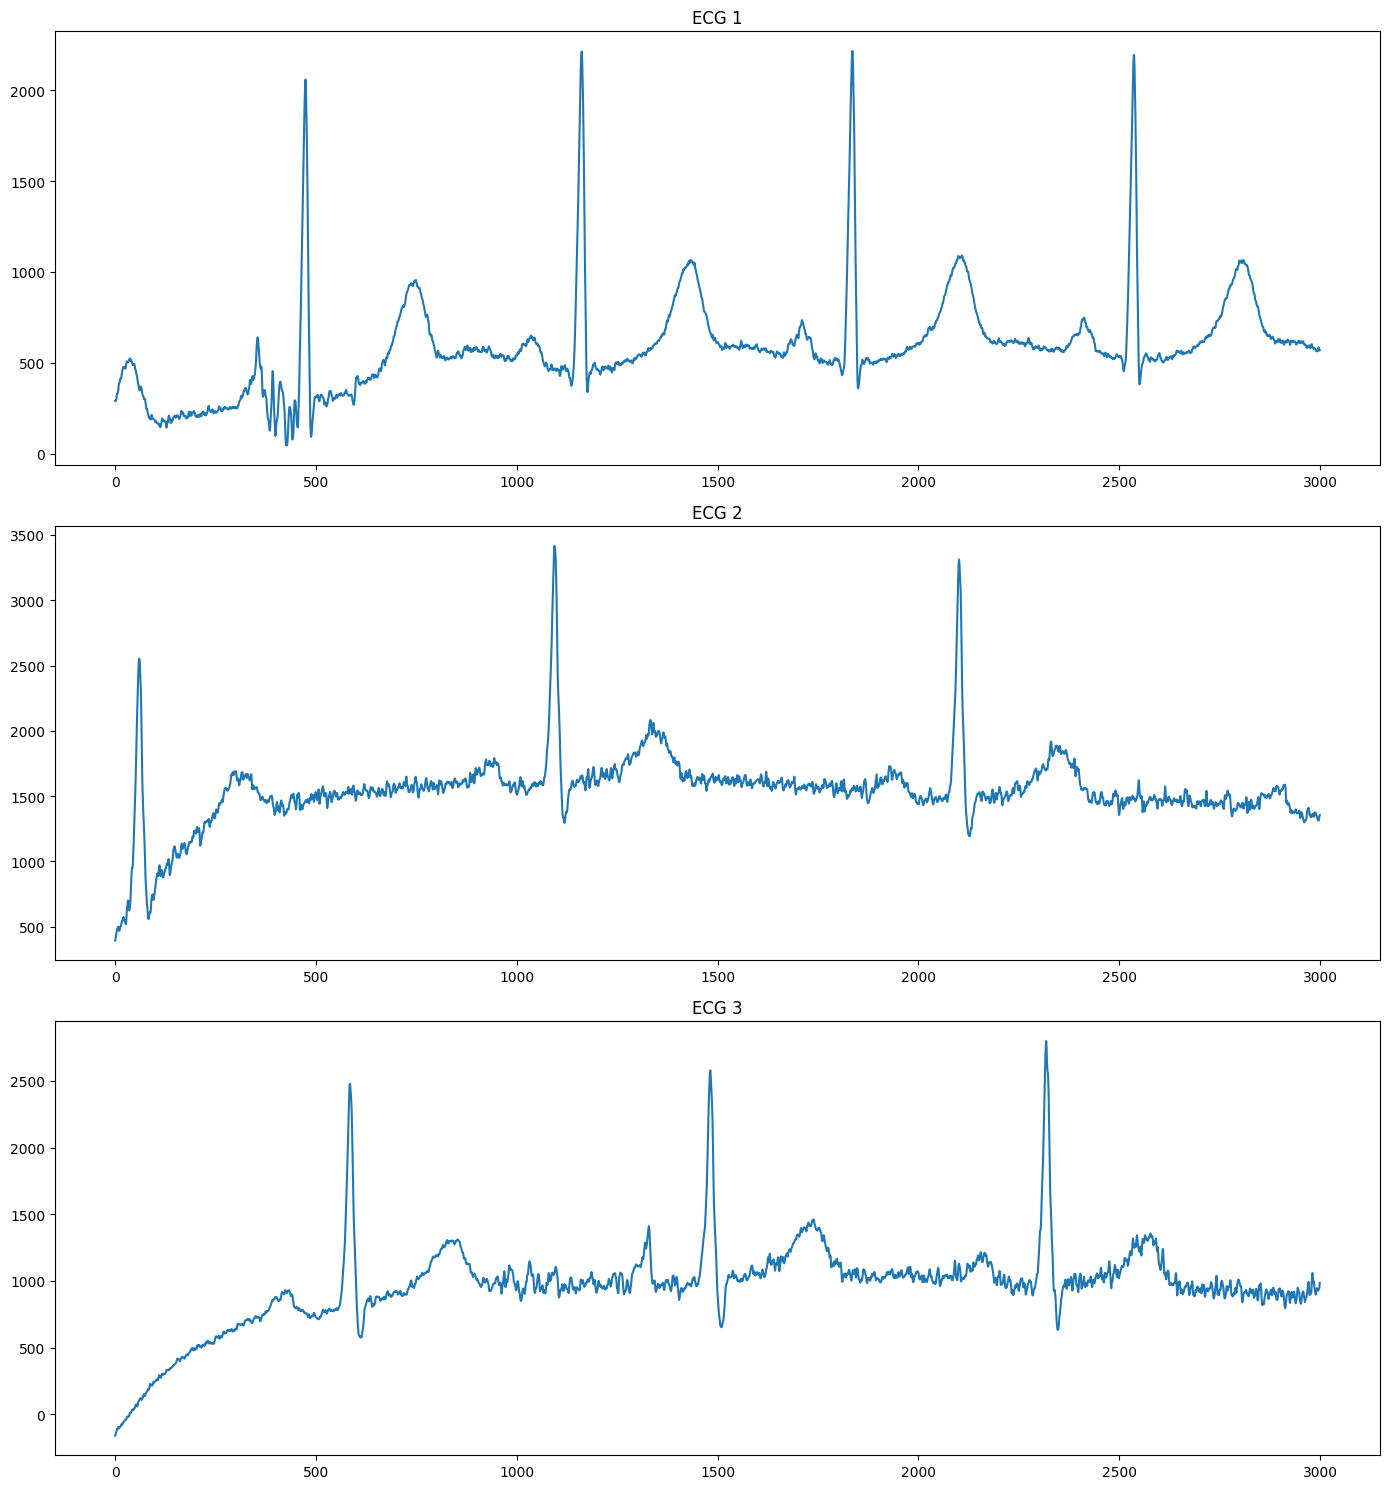

In [29]:
# Looking deeply at the data -- let's see the ECG peaks

fig, axs = plt.subplots(3, 1, figsize=(14, 15))

# Plot ECG and PPG for the first dataset
axs[0].plot(ecg1[:3000])
axs[0].set_title('ECG 1')

# Plot ECG and PPG for the second dataset
axs[1].plot(ecg2[:3000])
axs[1].set_title('ECG 2')

# Plot ECG and PPG for the third dataset
axs[2].plot(ecg3[:3000])
axs[2].set_title('ECG 3')

# Adjust layout for better readability
plt.tight_layout()
plt.show()

Looking at three ECG plots, we may assume that typical RR-interval for ECG1 is $\sim 700$ samples, for ECG2 is $\sim 1000$ samples and $\sim 900$ for ECG3

In [30]:
def detect_sampling_freq(signal, bps, distance=None):
    """
    Detect the sampling frequency of a given signal.

    Parameters:
    signal (np.array): The signal array.
    bps (int or float): Pre-known HR in beats per second
    distance (int): Typical distance between the peaks

    Returns:
    sampling_frequency (float): The detected sampling frequency.
    """
    peaks, _ = find_peaks(data, distance=distance)
    sum_interval = np.sum(np.diff(peaks))
    n = len(peaks)
    frequency = sum_interval / n / bps
    return frequency

In [31]:
ecg1_sf = detect_sampling_freq(ecg1, 1, 700)
print(f'The first ECG sampling frequency is ~{ecg1_sf} Hz')

ecg2_sf = detect_sampling_freq(ecg1, 1, 1000)
print(f'The Second ECG sampling frequency is ~{ecg2_sf} Hz')

ecg3_sf = detect_sampling_freq(ecg1, 1, 900)
print(f'The third ECG sampling frequency is ~{ecg3_sf} Hz')

The first ECG sampling frequency is ~807.927536231884 Hz
The Second ECG sampling frequency is ~1419.8846153846155 Hz
The third ECG sampling frequency is ~1419.8846153846155 Hz


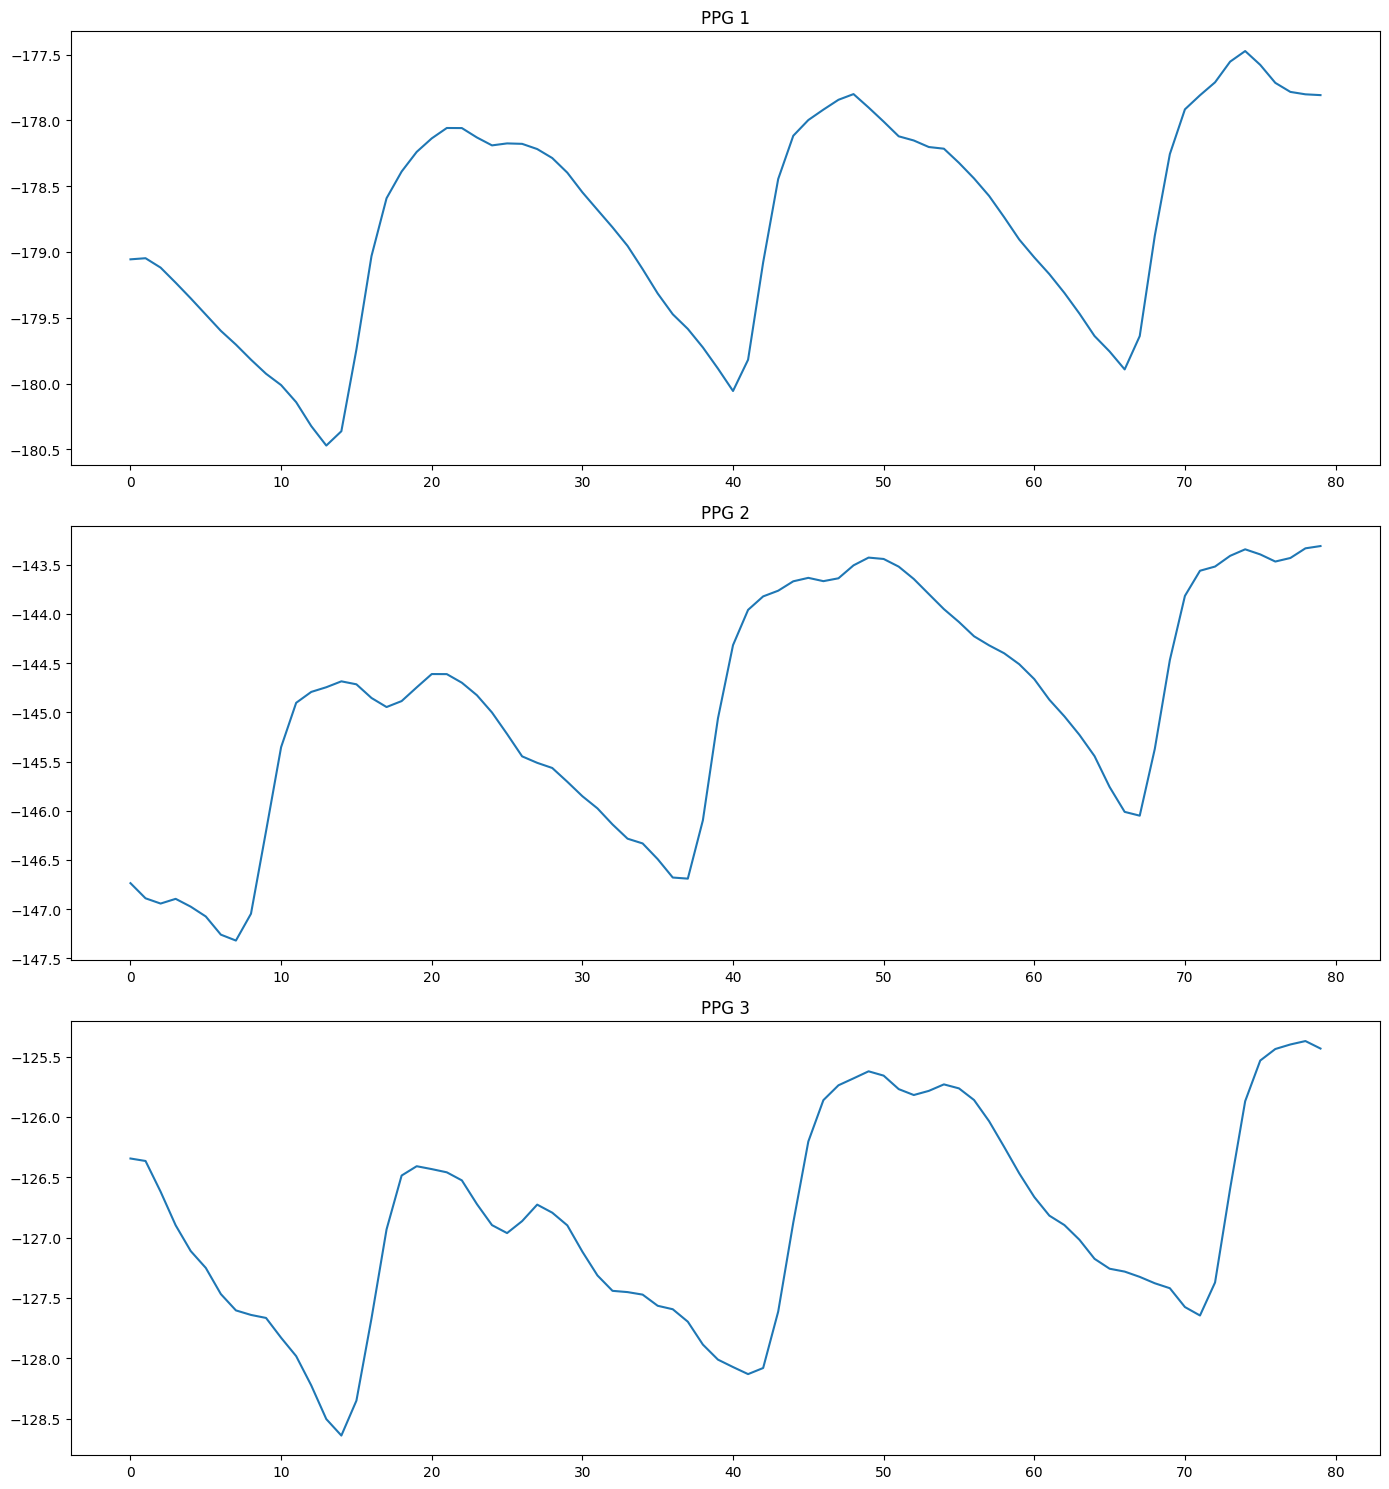

In [32]:
# PPG 

fig, axs = plt.subplots(3, 1, figsize=(14, 15))

# Plot ECG and PPG for the first dataset
axs[0].plot(ppg1[200:280])
axs[0].set_title('PPG 1')

# Plot ECG and PPG for the second dataset
axs[1].plot(ppg2[200:280])
axs[1].set_title('PPG 2')

# Plot ECG and PPG for the third dataset
axs[2].plot(ppg3[200:280])
axs[2].set_title('PPG 3')

# Adjust layout for better readability
plt.tight_layout()
plt.show()

For all PPGs the distance is $\sim 30$ samples

In [33]:
ppg1_sf = detect_sampling_freq(ppg1, 1, 30)
print(f'The first ECG sampling frequency is ~{ppg1_sf} Hz')

ppg2_sf = detect_sampling_freq(ppg2, 1, 30)
print(f'The Second ECG sampling frequency is ~{ppg2_sf} Hz')

ppg3_sf = detect_sampling_freq(ppg3, 1, 30)
print(f'The third ECG sampling frequency is ~{ppg3_sf} Hz')

The first ECG sampling frequency is ~50.7 Hz
The Second ECG sampling frequency is ~38.54794520547945 Hz
The third ECG sampling frequency is ~38.142857142857146 Hz


### Task 2: Preprocess the signals to remove high frequency noise, offset and trend.

In [34]:
# preprocessing functions

# Remove DC Offset
def remove_dc_offset(signal):
    mean = np.mean(signal)
    return signal - mean

# Lowpass Filter
def lowpass_filter(signal, cutoff, fs, order=5):
    nyquist = 0.5 * fs
    norm_cutoff = cutoff / nyquist
    b, a = butter(order, norm_cutoff, btype='low')
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

# Remove Trend
def remove_trend_differencing(signal):
    detrended_signal = np.diff(signal, prepend=signal[0])
    return detrended_signal

# Full Signal Preprocessing
def preprocess_signal(signal, fs, cutoff):
    # Step 1: Remove DC Offset
    signal_no_dc = remove_dc_offset(signal)
    
    # Step 2: Apply Lowpass Filter
    filtered_signal = lowpass_filter(signal_no_dc, cutoff, fs)
    
    # Step 3: Remove Trend
    preprocessed_signal = remove_trend_differencing(filtered_signal)
    
    return preprocessed_signal

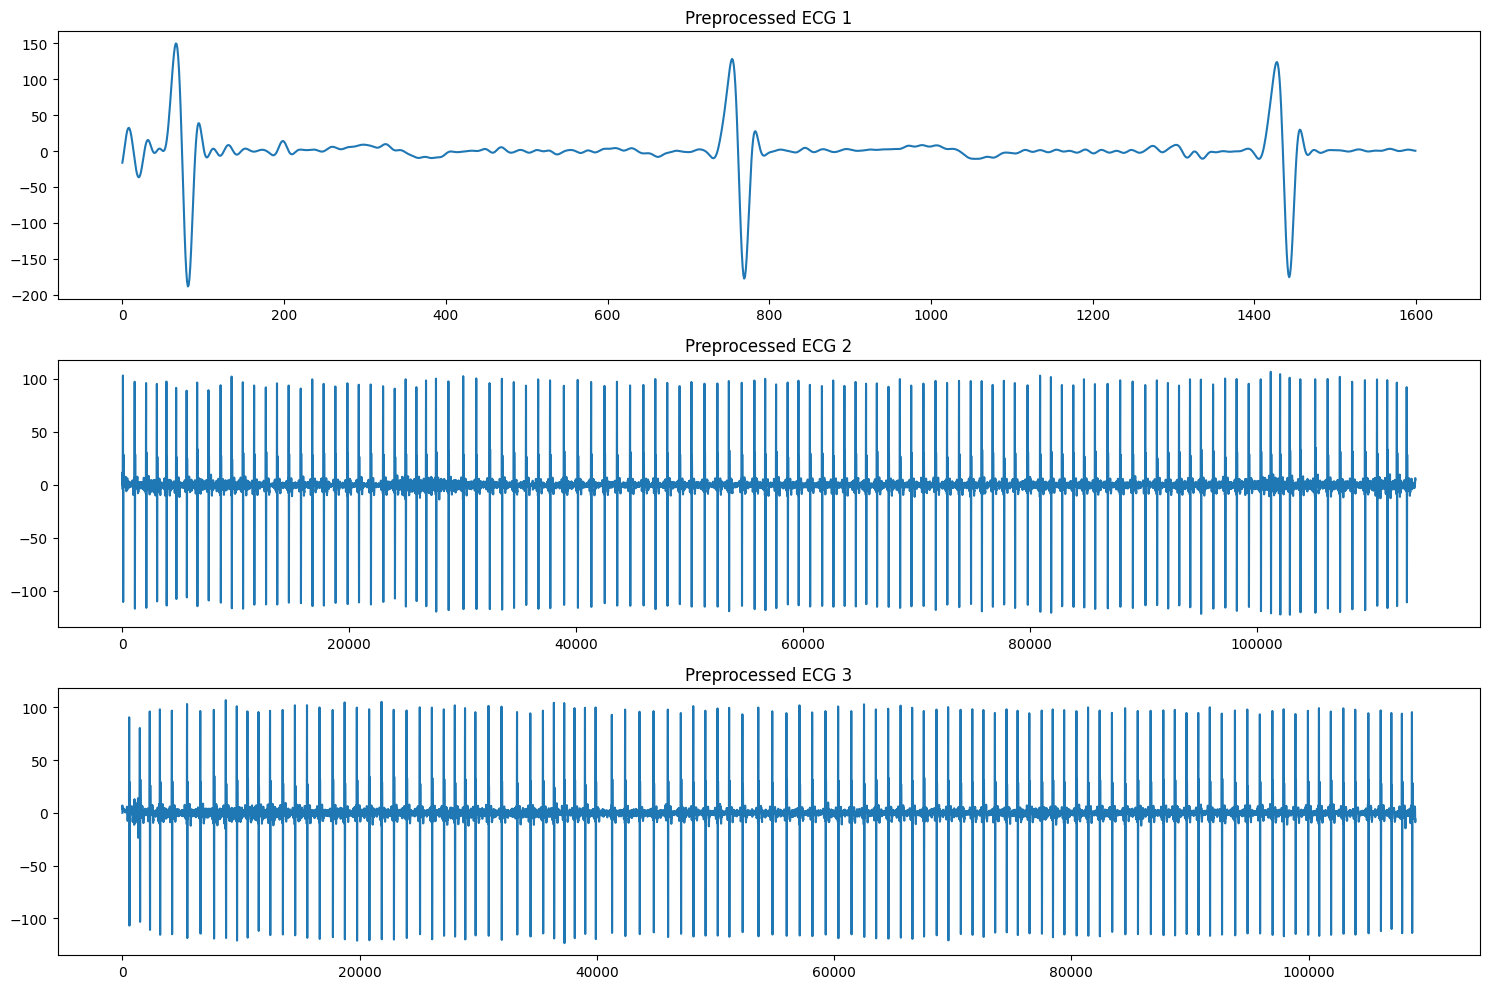

In [35]:
# Filter parameter -- usually 40-50 Hz
ecg_cutoff = 45

# Signal Preprocessing
ecg1_preprocessed = preprocess_signal(ecg1, ecg1_sf, ecg_cutoff)
ecg2_preprocessed = preprocess_signal(ecg2, ecg2_sf, ecg_cutoff)
ecg3_preprocessed = preprocess_signal(ecg3, ecg3_sf, ecg_cutoff)

plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.plot(ecg1_preprocessed[400:2000])
plt.title('Preprocessed ECG 1')

plt.subplot(3, 1, 2)
plt.plot(ecg2_preprocessed)
plt.title('Preprocessed ECG 2')

plt.subplot(3, 1, 3)
plt.plot(ecg3_preprocessed)
plt.title('Preprocessed ECG 3')

plt.tight_layout()
plt.show()

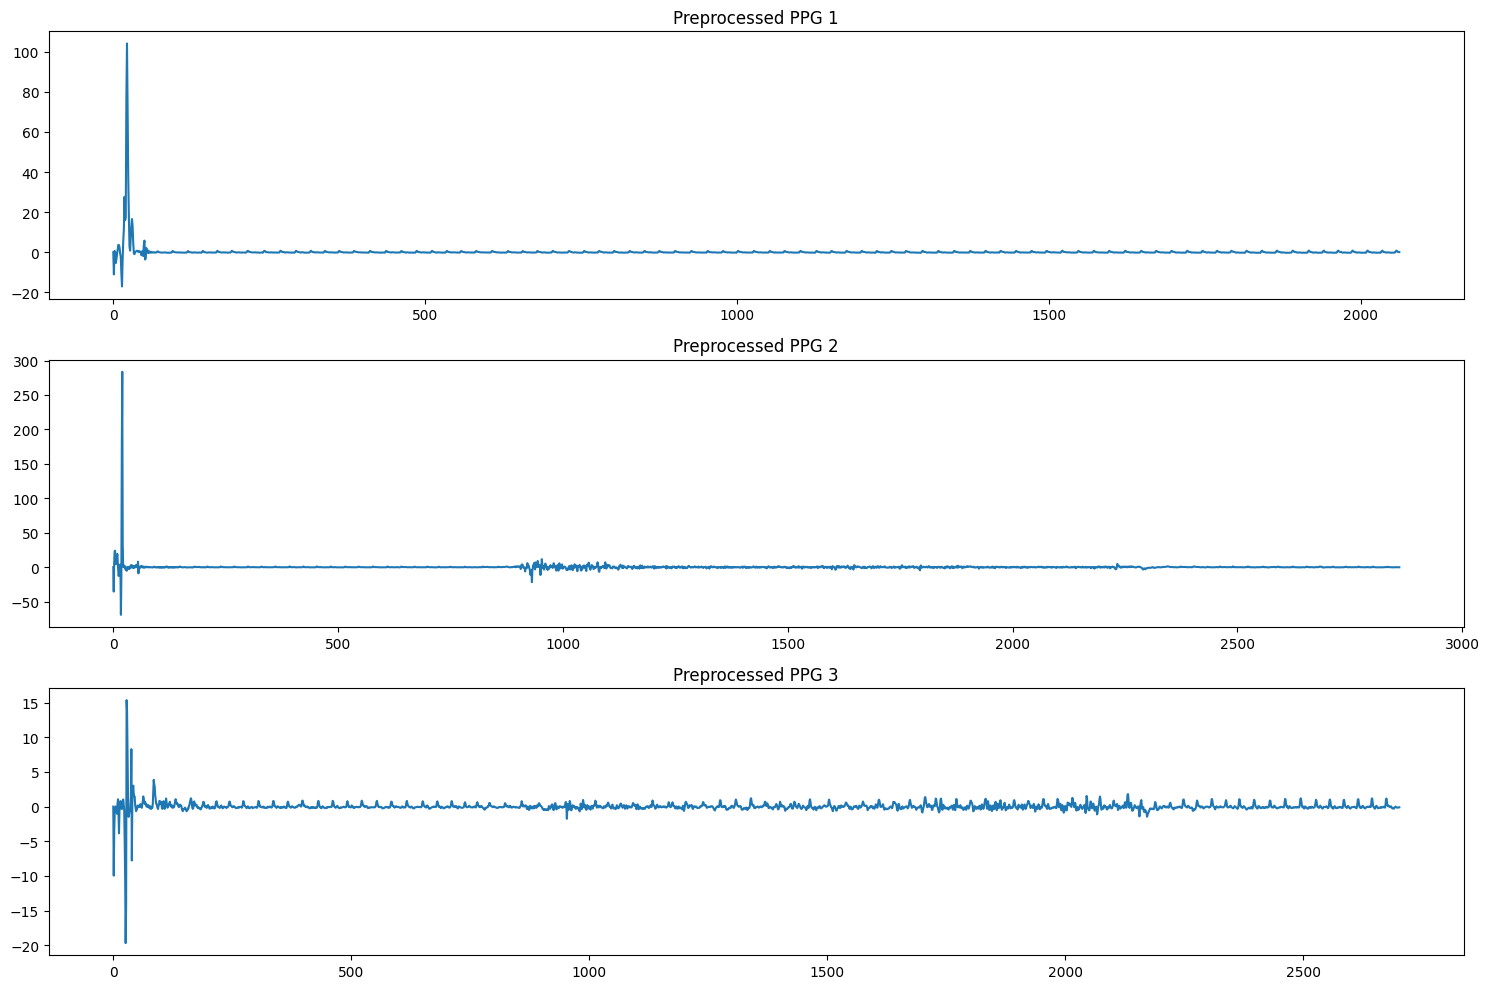

In [58]:
# High-frequency noise in PPGs is usually close to 20 Hz
ppg_cutoff = 19

# Signal Preprocessing
ppg1_preprocessed = preprocess_signal(ppg1, ppg1_sf, ppg_cutoff)
ppg2_preprocessed = preprocess_signal(ppg2, ppg2_sf, ppg_cutoff)
ppg3_preprocessed = preprocess_signal(ppg3, ppg3_sf, ppg_cutoff)

plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.plot(ppg1_preprocessed)
plt.title('Preprocessed PPG 1')

plt.subplot(3, 1, 2)
plt.plot(ppg2_preprocessed)
plt.title('Preprocessed PPG 2')

plt.subplot(3, 1, 3)
plt.plot(ppg3_preprocessed)
plt.title('Preprocessed PPG 3')

plt.tight_layout()
plt.show()

### Task 3: Puls location

In [37]:
# Peaks detection
ecg1_peaks, _ = find_peaks(ecg1_preprocessed, distance=700)
ecg2_peaks, _ = find_peaks(ecg2_preprocessed, distance=1000)
ecg3_peaks, _ = find_peaks(ecg3_preprocessed, distance=900)

ppg1_peaks, _ = find_peaks(ppg1_preprocessed, distance=ppg1_sf/2)
ppg2_peaks, _ = find_peaks(ppg2_preprocessed, distance=ppg2_sf/2)
ppg3_peaks, _ = find_peaks(ppg3_preprocessed, distance=ppg3_sf/2)

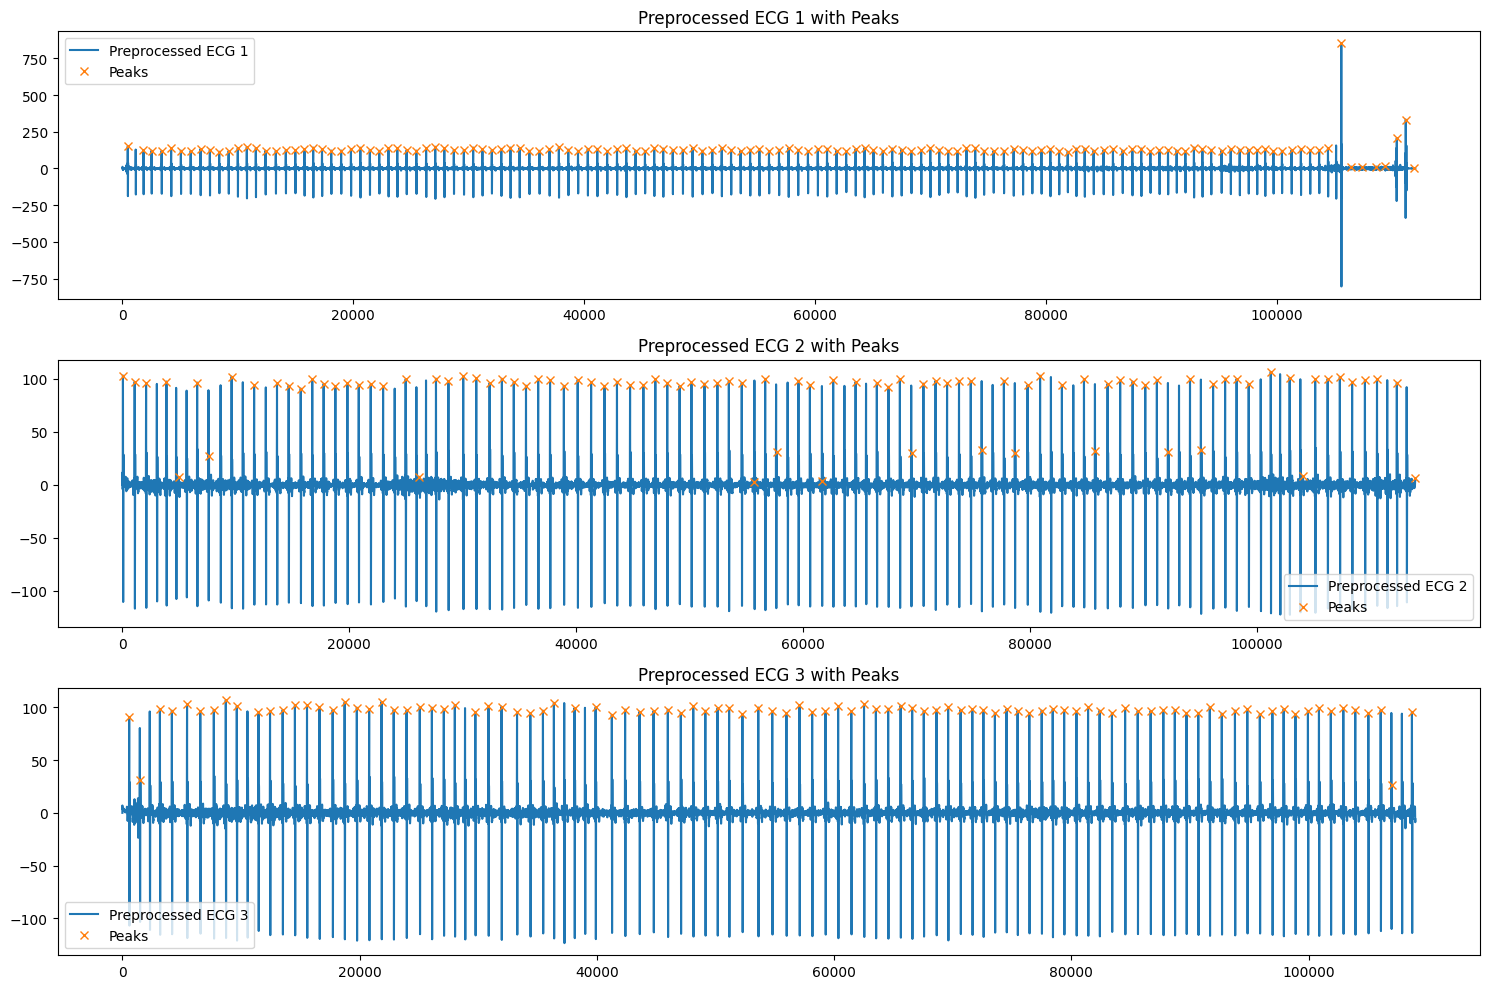

In [38]:
# ECG Peaks Vizualized

plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.plot(ecg1_preprocessed, label='Preprocessed ECG 1')
plt.plot(ecg1_peaks, ecg1_preprocessed[ecg1_peaks], "x", label='Peaks')
plt.title('Preprocessed ECG 1 with Peaks')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(ecg2_preprocessed, label='Preprocessed ECG 2')
plt.plot(ecg2_peaks, ecg2_preprocessed[ecg2_peaks], "x", label='Peaks')
plt.title('Preprocessed ECG 2 with Peaks')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(ecg3_preprocessed, label='Preprocessed ECG 3')
plt.plot(ecg3_peaks, ecg3_preprocessed[ecg3_peaks], "x", label='Peaks')
plt.title('Preprocessed ECG 3 with Peaks')
plt.legend()

plt.tight_layout()
plt.show()

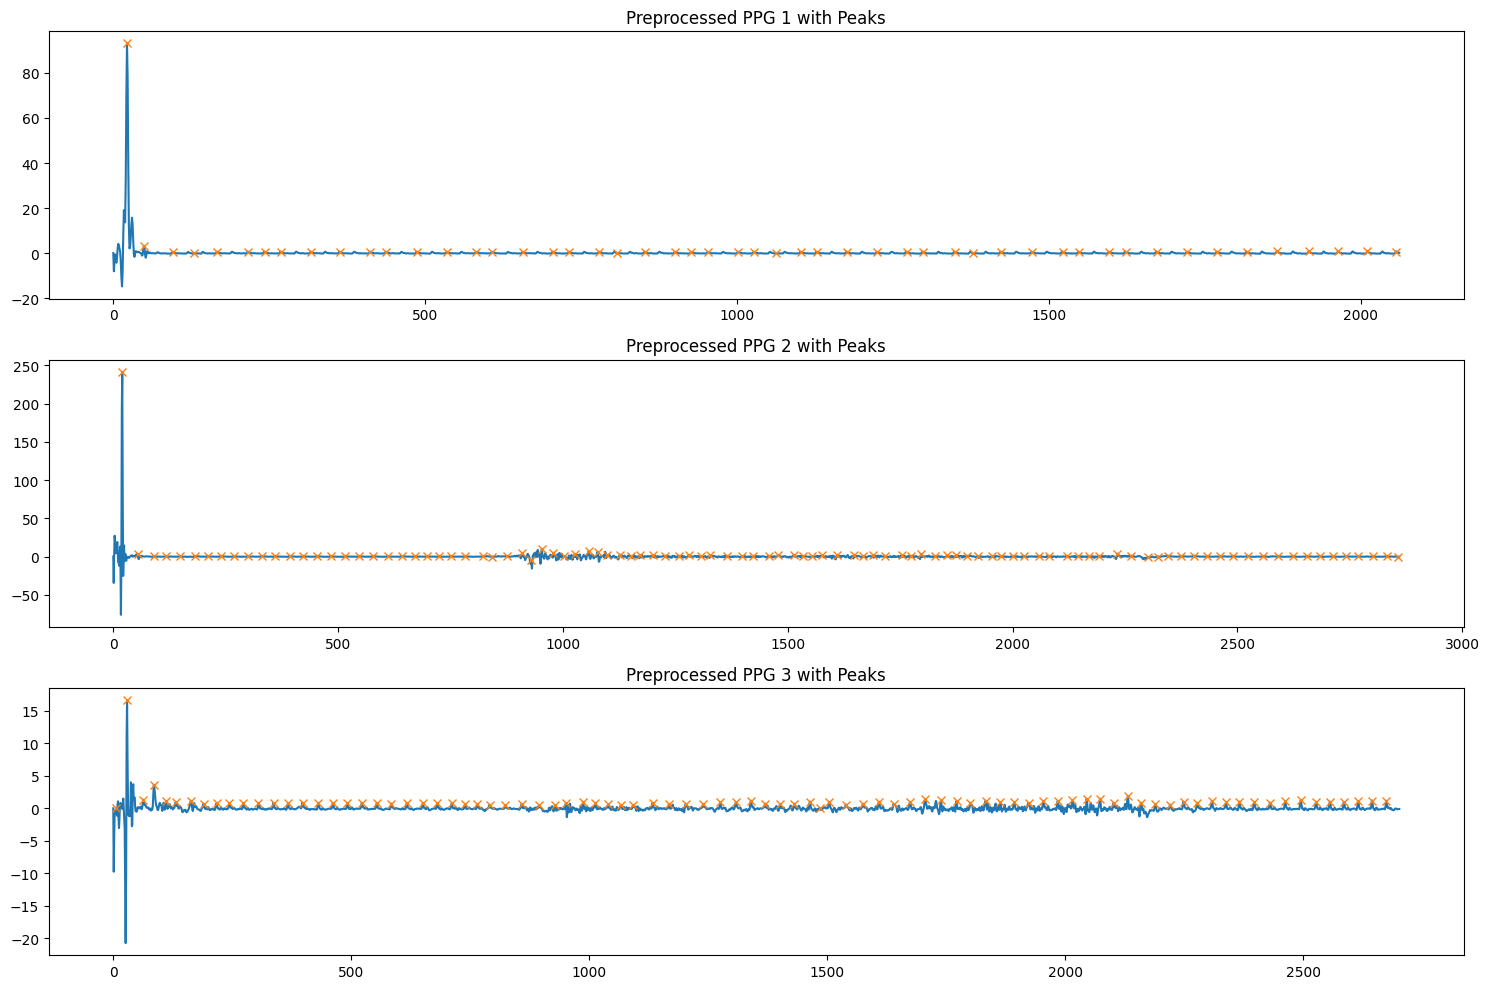

In [39]:
# PPG Peaks Vizualized

plt.figure(figsize=(15, 10))
plt.subplot(3, 1, 1)
plt.plot(ppg1_preprocessed)
plt.plot(ppg1_peaks, ppg1_preprocessed[ppg1_peaks], "x")
plt.title('Preprocessed PPG 1 with Peaks')

plt.subplot(3, 1, 2)
plt.plot(ppg2_preprocessed)
plt.plot(ppg2_peaks, ppg2_preprocessed[ppg2_peaks], "x")
plt.title('Preprocessed PPG 2 with Peaks')

plt.subplot(3, 1, 3)
plt.plot(ppg3_preprocessed)
plt.plot(ppg3_peaks, ppg3_preprocessed[ppg3_peaks], "x")
plt.title('Preprocessed PPG 3 with Peaks')

plt.tight_layout()
plt.show()

### Task 4: Anomalies and outliers detection

In [46]:
from scipy.signal import stft

def detect_outliers_stft(signal, fs, perc_threshold=75, nperseg=256):
    f, t, Zxx = stft(signal, fs, nperseg=nperseg)
    magnitude = np.abs(Zxx)
    threshold = np.percentile(magnitude, perc_threshold)
    outliers = np.where(magnitude > threshold)[0]
    return outliers

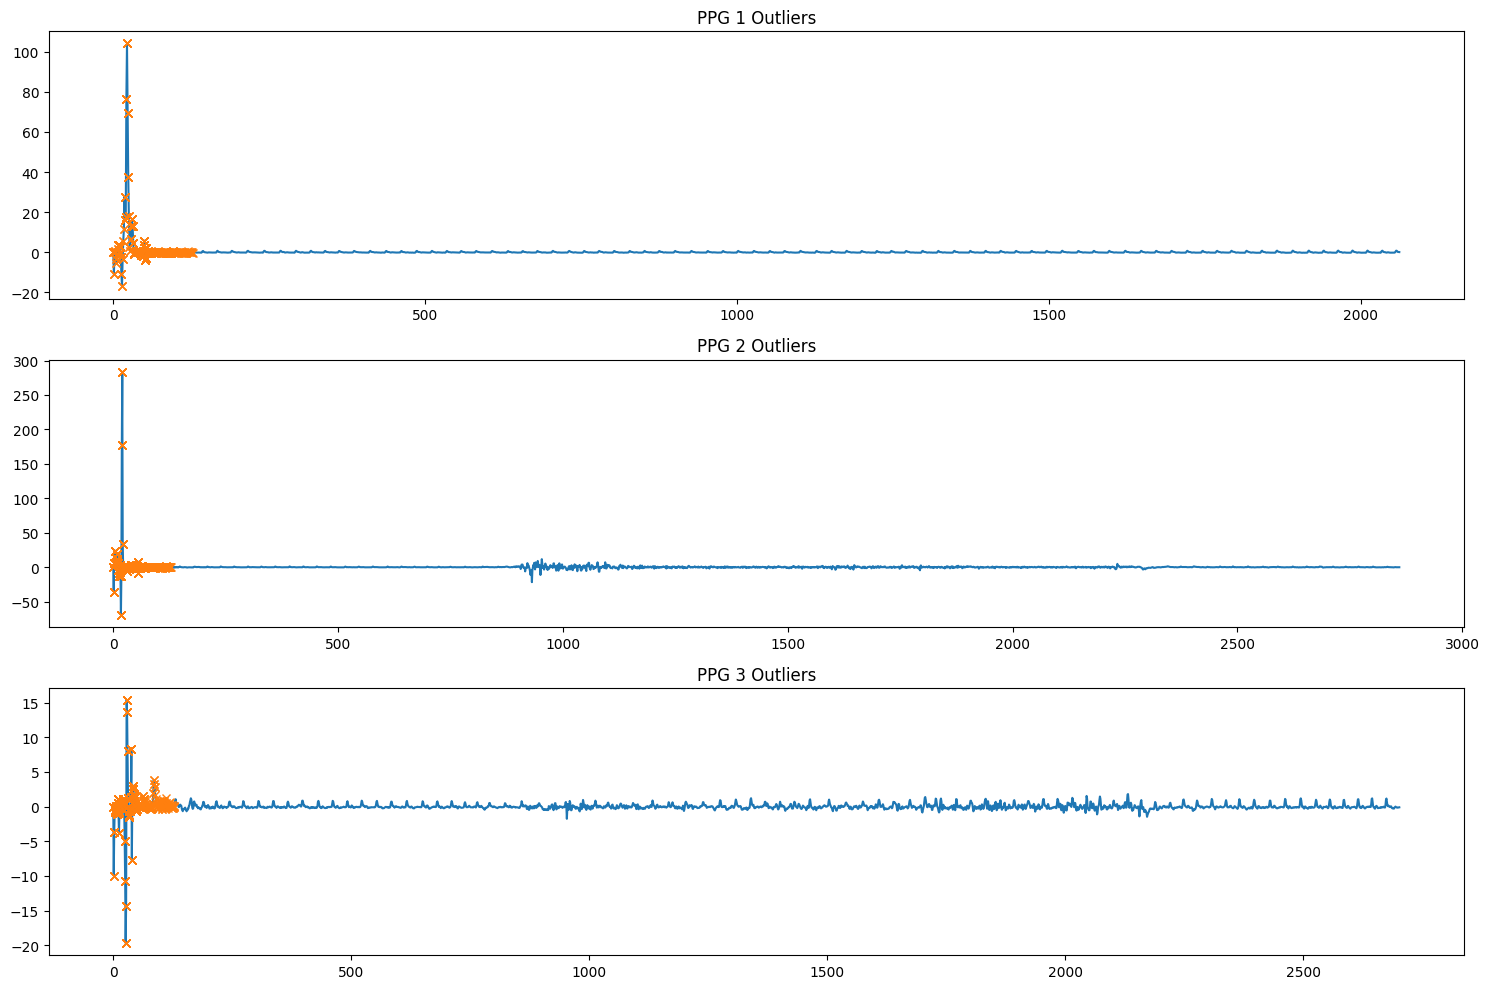

In [83]:
ppg1_outliers = detect_outliers_stft(ppg1_preprocessed, ppg1_sf)
ppg2_outliers = detect_outliers_stft(ppg2_preprocessed, ppg2_sf)
ppg3_outliers = detect_outliers_stft(ppg3_preprocessed, ppg3_sf)


# Peaks detected
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.plot(ppg1_preprocessed)
plt.plot(ppg1_outliers, ppg1_preprocessed[ppg1_outliers], "x")
plt.title('PPG 1 Outliers')

plt.subplot(3, 1, 2)
plt.plot(ppg2_preprocessed)
plt.plot(ppg2_outliers, ppg2_preprocessed[ppg2_outliers], "x")
plt.title('PPG 2 Outliers')

plt.subplot(3, 1, 3)
plt.plot(ppg3_preprocessed)
plt.plot(ppg3_outliers, ppg3_preprocessed[ppg3_outliers], "x")
plt.title('PPG 3 Outliers')

plt.tight_layout()
plt.show()

### Task 5: Sygnals synchronization

In [71]:
def synchronize_signals(ecg_signal, ppg_signal, sampling_frequency_ecg, sampling_frequency_ppg):
    """
    Synchronize ECG and PPG signals.

    Parameters:
    ecg_signal (array-like): The ECG signal data.
    ppg_signal (array-like): The PPG signal data.
    sampling_frequency_ecg (int or float): The sampling frequency of the ECG signal in Hz.
    sampling_frequency_ppg (int or float): The sampling frequency of the PPG signal in Hz.

    Returns:
    resampled_ecg_signal (numpy array): The resampled ECG signal synchronized with the PPG signal.
    ppg_signal (numpy array): The original PPG signal.
    desired_sampling_frequency (int or float): The sampling frequency used for resampling.
    """

    # Step 1: Calculate the time vector for the PPG signal
    ppg_time = np.arange(len(ppg_signal)) / sampling_frequency_ppg

    # Step 2: Determine the start and end times for the PPG signal
    start_time_ppg = ppg_time[0]
    end_time_ppg = ppg_time[-1]

    # Step 3: Convert these times to corresponding indices in the ECG signal
    start_index_ecg = int(start_time_ppg * sampling_frequency_ecg)
    end_index_ecg = int(end_time_ppg * sampling_frequency_ecg)

    # Step 4: Trim the ECG signal
    trimmed_ecg_signal = ecg_signal[start_index_ecg:end_index_ecg+1]

    # Step 5: Resample signals to have the same sampling frequency
    desired_sampling_frequency = sampling_frequency_ppg  # or any other desired frequency

    # Resample ECG to match the PPG sampling frequency
    number_of_samples_ecg = int(len(trimmed_ecg_signal) * desired_sampling_frequency / sampling_frequency_ecg)
    resampled_ecg_signal = resample(trimmed_ecg_signal, number_of_samples_ecg)

    return resampled_ecg_signal, ppg_signal, desired_sampling_frequency

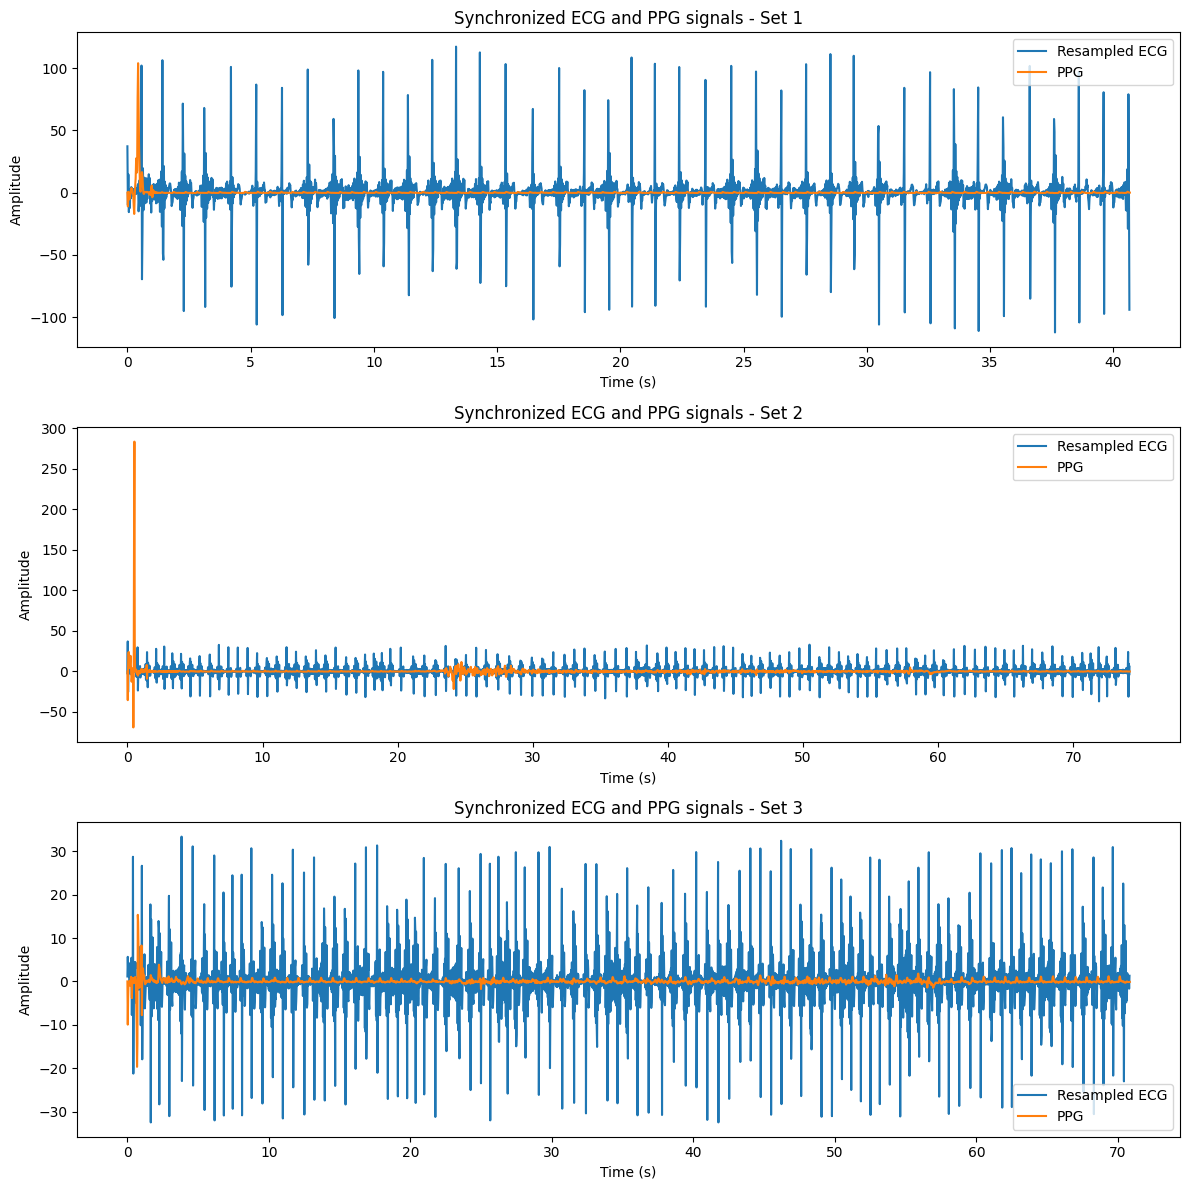

In [76]:
ecg1_resampled, ppg1_sync, sf1 = synchronize_signals(
    ecg1_preprocessed,
    ppg1_preprocessed,
    ecg1_sf,
    ppg1_sf)


ecg2_resampled, ppg2_sync, sf2 = synchronize_signals(
    ecg2_preprocessed,
    ppg2_preprocessed,
    ecg2_sf,
    ppg2_sf)

ecg3_resampled, ppg3_sync, sf3 = synchronize_signals(
    ecg3_preprocessed,
    ppg3_preprocessed,
    ecg3_sf,
    ppg3_sf)


# Plot the synchronized signals for verification
plt.figure(figsize=(12, 12))

plt.subplot(3, 1, 1)
plt.plot(np.arange(len(ecg1_resampled)) / sf1, ecg1_resampled, label='Resampled ECG')
plt.plot(np.arange(len(ppg1_sync)) / sf1, ppg1_sync, label='PPG')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Synchronized ECG and PPG signals - Set 1')

plt.subplot(3, 1, 2)
plt.plot(np.arange(len(ecg2_resampled)) / sf2, ecg2_resampled, label='Resampled ECG')
plt.plot(np.arange(len(ppg2_sync)) / sf2, ppg2_sync, label='PPG')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Synchronized ECG and PPG signals - Set 2')

plt.subplot(3, 1, 3)
plt.plot(np.arange(len(ecg3_resampled)) / sf3, ecg3_resampled, label='Resampled ECG')
plt.plot(np.arange(len(ppg3_sync)) / sf3, ppg3_sync, label='PPG')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Synchronized ECG and PPG signals - Set 3')

plt.tight_layout()
plt.show()

### Task 6: PPG evaluation

To evaluate the PPG signals we will use the Signal-to-Noise-Ratio (SNR):

$$SNR = 10 \cdot \log_{10} \frac{Power \; of \; Signal}{Power \; of \; Noise}$$

The larger SNR the better.

Let's start!

In [80]:
def calculate_snr(signal, noise_signal):
    """
    Calculate the Signal-to-Noise Ratio (SNR) of a signal.

    Parameters:
    signal (array-like): The PPG signal data.
    noise_signal (array-like): The noise data extracted from the PPG signal.

    Returns:
    float: The SNR value in dB.
    """
    signal_power = np.mean(signal**2)
    noise_power = np.mean(noise_signal**2)
    snr = 10 * np.log10(signal_power / noise_power)
    return snr


def extract_noise(signal, method='simple'):
    """
    Extract noise from the signal using a specified method.

    Parameters:
    signal (array-like): The PPG signal data.
    method (str): The method to use for noise extraction. Default is 'simple'.

    Returns:
    array-like: The extracted noise signal.
    """
    if method == 'simple':
        # A simple method to extract noise is to subtract a smoothed version of the signal from the original signal
        smoothed_signal = savgol_filter(signal, window_length=51, polyorder=3)
        noise_signal = signal - smoothed_signal
    else:
        raise ValueError("Unsupported method for noise extraction.")
    
    return noise_signal

SNR values (dB): [27.22511594815429, 21.241121589821283, 39.17631424096898]
Order of signals from best to worst: [3 1 2]


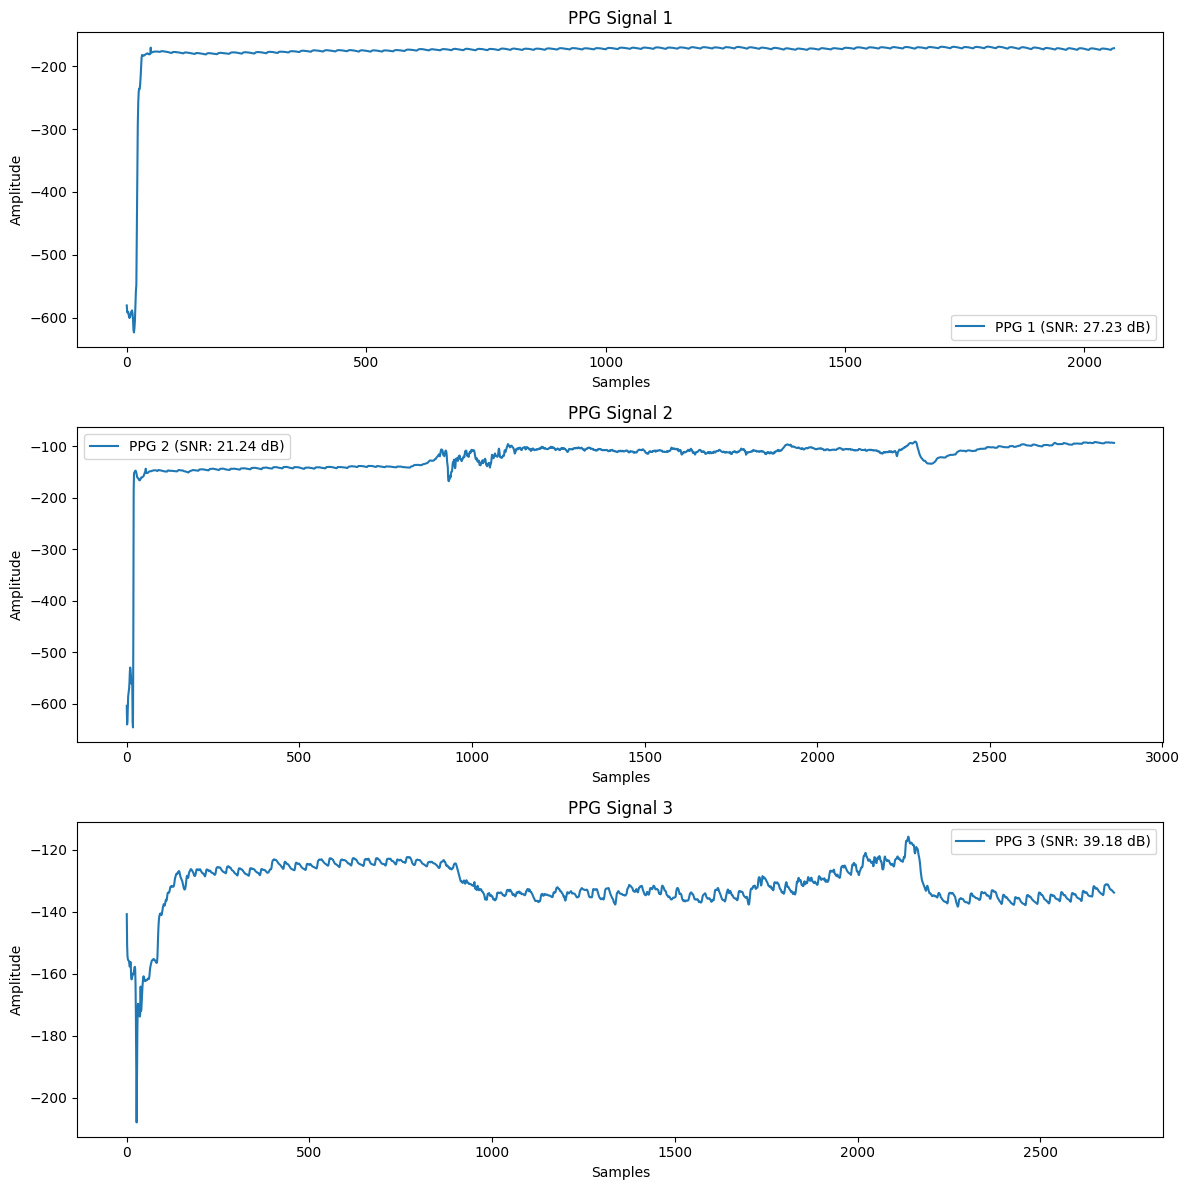

In [82]:
noise_ppg1 = extract_noise(ppg1)
noise_ppg2 = extract_noise(ppg2)
noise_ppg3 = extract_noise(ppg3)

# Calculate SNR for each PPG signal
snr_ppg1 = calculate_snr(ppg1, noise_ppg1)
snr_ppg2 = calculate_snr(ppg2, noise_ppg2)
snr_ppg3 = calculate_snr(ppg3, noise_ppg3)

# Order the signals from best to worst based on SNR
snr_values = [snr_ppg1, snr_ppg2, snr_ppg3]
ordered_indices = np.argsort(snr_values)[::-1]  # Descending order

# Output the results
print("SNR values (dB):", snr_values)
print("Order of signals from best to worst:", ordered_indices + 1)  # +1 to match signal number

# Plotting for verification (optional)
plt.figure(figsize=(12, 12))

plt.subplot(3, 1, 1)
plt.plot(ppg1, label=f'PPG 1 (SNR: {snr_ppg1:.2f} dB)')
plt.legend()
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.title('PPG Signal 1')

plt.subplot(3, 1, 2)
plt.plot(ppg2, label=f'PPG 2 (SNR: {snr_ppg2:.2f} dB)')
plt.legend()
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.title('PPG Signal 2')

plt.subplot(3, 1, 3)
plt.plot(ppg3, label=f'PPG 3 (SNR: {snr_ppg3:.2f} dB)')
plt.legend()
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.title('PPG Signal 3')

plt.tight_layout()
plt.show()